In [3]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw
#os.chdir('code')

from utils.utils import CustomDataset
from models.model_SE import *
from models.model_ECA import *
from utils.helper import *

In [4]:
with open('eval_metrics/training_dice_ECA.json') as json_data:
    training_dice_ECA = json.load(json_data)

with open('eval_metrics/training_loss_ECA.json') as json_data:
    training_loss_ECA = json.load(json_data)

In [5]:
with open('eval_metrics/training_dice_se.json') as json_data:
    training_dice_se = json.load(json_data)

with open('eval_metrics/training_loss_se.json') as json_data:
    training_loss_se = json.load(json_data)

In [6]:
dice_SE = [0.3634018602176736,
 0.32112285915418676,
 0.22817648539291038,
 0.43609690662633877,
 0.42171861426135543,
 0.20486982020747366,
 0.40276096171172643,
 0.34801071302056186,
 0.2707074142569328,
 0.4183671265072994,
 0.391337973704563,
 0.3385186546757529,
 0.36064619414932325,
 0.3779017471409012,
 0.39990209191121834,
 0.21898747725569945,
 0.37601282935669117,
 0.39492450997801176,
 0.3251323931418637,
 0.24375734606251048,
 0.5846072950255565,
 0.40350976655342496,
 0.3776573350646358,
 0.4797279058467851,
 0.38883876504632175,
 0.2795577643838192,
 0.31550660651057066,
 0.29276425475158385,
 0.35038910593504835,
 0.5717657661523936,
 0.3154833529280487,
 0.4539038842455137,
 0.24422062350119905,
 0.3125054739394386,
 0.3629188234373428,
 0.42824420434370997,
 0.3913061628951919,
 0.2718992444751805,
 0.27314645565291223,
 0.5742188641032882,
 0.28202029682642105,
 0.33081414303073414,
 0.27220510012884835,
 0.3221231961609768,
 0.1518205133383146,
 0.34125896306029746,
 0.3471865419953135,
 0.30335500794838877,
 0.27328085128461527,
 0.44211332638253503,
 0.2036982970757594,
 0.6209442583921313,
 0.16801074932503948,
 0.40244381409557056,
 0.27197265970729084,
 0.2818388754605402,
 0.17219548241497074,
 0.3711643407438059,
 0.3587094922974839,
 0.2547507127260939,
 0.3313125051280415,
 0.41727987271831146,
 0.4114696335896412,
 0.5016065325501914,
 0.4127610404982668,
 0.2272627121311539,
 0.4361536933523289,
 0.26446849110497433,
 0.5263458747707982,
 0.31874806250502313,
 0.3268088568340178,
 0.2532517726097205,
 0.30656110428795125,
 0.26962845319209783,
 0.4022172029635449,
 0.29379468488707017,
 0.47523527684467665,
 0.3545967957606417,
 0.22197613791730111,
 0.3163394364189099,
 0.3683038748771481,
 0.5658319491020779,
 0.2206884819616754,
 0.40458125051752614,
 0.353557068712727,
 0.2768894767313241,
 0.3948330179971806,
 0.2656278500143315,
 0.2465333492994851,
 0.35721802267530955,
 0.26197185104650583,
 0.3280124595225372,
 0.27945669032288384,
 0.29069566557251514,
 0.25863594417436475,
 0.32712234243085464,
 0.25354343480604735,
 0.29086325225267284,
 0.44752092314151404,
 0.1812129552805338,
 0.31585533322445525,
 0.436637883174896,
 0.39024862145690237,
 0.6281457220428667,
 0.49254880645015175,
 0.3175194810268242,
 0.43141959782846223,
 0.37752791061511937,
 0.368016548083953,
 0.17894202739944087,
 0.35520669994473625,
 0.6021505376344086,
 0.24981115477658894,
 0.3411687673181972,
 0.26167061583243506,
 0.3543859964577583,
 0.2974923729444155,
 0.25117816647916325,
 0.29496682665325297,
 0.2765447094187905,
 0.28760939831511395,
 0.2525263615143371,
 0.3927258198709632,
 0.19452458806180675,
 0.2067911515175265,
 0.3393364240934123,
 0.391966862429005,
 0.4801192388971232,
 0.26239670402172005,
 0.2880017958023121,
 0.2678435816573493,
 0.37239183883976007,
 0.2854801128713103,
 0.4285646830558167,
 0.27656499366799586,
 0.4076762808662784,
 0.23623928906105085,
 0.4767833032015928,
 0.1952722522122803,
 0.3636725288920774,
 0.24337390444794732,
 0.4253810949382334,
 0.23834845167344385,
 0.15029836342231181,
 0.29042825687473584,
 0.27516425941325995,
 0.44835003676945867,
 0.3335343883791701,
 0.21521465154318506,
 0.5782334721777208,
 0.40069550173766216,
 0.6313487241798299,
 0.5070694795052384,
 0.4049357756592363,
 0.4278493298347026,
 0.24509597131406877,
 0.31563061477550103,
 0.3230762535815799,
 0.29970646156132724,
 0.3659841901114548,
 0.4273461681383805,
 0.2759521987402131,
 0.2936992533069831,
 0.3010400374988978,
 0.2166101562804474,
 0.41347987379953544,
 0.36336161804021855,
 0.5563330986901389,
 0.4308581887230791,
 0.33346231762001227,
 0.30447871798434534,
 0.3635774392901445,
 0.5674034186963872,
 0.41522094394960984,
 0.28941773476816396,
 0.30109128710619804,
 0.5960337031682051,
 0.3881009726521393,
 0.22141463805680997,
 0.35830098861600485,
 0.2864030519700888,
 0.36566321268968227,
 0.38867565759357725,
 0.41006564646458066,
 0.40458820350565244,
 0.2607249671581658,
 0.1889958543993826,
 0.3461897264807064,
 0.451939199032462,
 0.2571519707494037,
 0.30553819806058924,
 0.26375648577634864,
 0.22890082802563178,
 0.24581495475335366,
 0.32915713901021915,
 0.47743583025039876,
 0.18197619703865933,
 0.24433850964443635,
 0.222718500807127,
 0.13341151576183252,
 0.3891755128980804,
 0.24649555373005286,
 0.3296260046860634,
 0.2804345885922843,
 0.2735862181172526,
 0.18659163636723897,
 0.2634929369017238,
 0.3706206089253565,
 0.2462603446830425,
 0.19370946294336347,
 0.33371643411311414,
 0.17959402878198688,
 0.417060873626041,
 0.2748757098089112,
 0.2658003879778962,
 0.33430022909741985]

In [7]:
dice_ECA = [0.6811993344897165,
 0.49254506342259474,
 0.4532846243372559,
 0.7010241612899231,
 0.7324774625949875,
 0.3666504509224264,
 0.48703394546466333,
 0.5499842845785494,
 0.5536333818810463,
 0.7025510605385281,
 0.6883440211241041,
 0.7067940723945259,
 0.6846640872317974,
 0.6404927201897757,
 0.755786866204188,
 0.3634044167083283,
 0.7023116062190853,
 0.6438648808265222,
 0.4890021864640745,
 0.6391179531755744,
 0.7697241966728727,
 0.7057889292983217,
 0.623396473606638,
 0.6885263606957517,
 0.6462822122129513,
 0.5231044677668233,
 0.6486429678673707,
 0.5987668908032396,
 0.6615057817836689,
 0.7575661112750198,
 0.5273166664907819,
 0.7524779402876828,
 0.5554816568677007,
 0.6649392913044632,
 0.5567529954855571,
 0.540310187820148,
 0.6943154478822805,
 0.49421674789092623,
 0.5432633078727758,
 0.7495376264459434,
 0.5599587557999657,
 0.6507272727272727,
 0.24169211027036594,
 0.610960220239085,
 0.2575598099735442,
 0.6053037090127217,
 0.6915325088954689,
 0.5137122871245056,
 0.527136049231385,
 0.7230018051075666,
 0.28770059904233364,
 0.7772975494635164,
 0.31394072447859495,
 0.7348301532521454,
 0.7325534998004914,
 0.5095408756296009,
 0.3867922397633083,
 0.41397173370371065,
 0.6026902024016634,
 0.4892605706570409,
 0.38467154852148516,
 0.704588538798226,
 0.7045816935437564,
 0.7081474982330433,
 0.7028818289148868,
 0.40188236859171556,
 0.6150210931556744,
 0.5568178955588583,
 0.7513958644405231,
 0.6431172752146429,
 0.5670519399549182,
 0.5459731812001812,
 0.5956063847293073,
 0.4687646905197179,
 0.6409332253742145,
 0.6520990348872898,
 0.7260330247819244,
 0.6528911102949395,
 0.3796045713891714,
 0.708551576223268,
 0.6659510718477791,
 0.7379998500762113,
 0.31425279907837417,
 0.7034156516048996,
 0.6857475610437058,
 0.6081007611453425,
 0.7535425857464931,
 0.5848577597456521,
 0.3981098816454102,
 0.40470477164548996,
 0.5222903687183341,
 0.6051477013720598,
 0.6616444161898707,
 0.5470915979496322,
 0.5183800294923109,
 0.6688089597243162,
 0.4777771627829745,
 0.536064883802937,
 0.6716712078243838,
 0.3008566995705259,
 0.5602577214154224,
 0.7433869122870387,
 0.4869957733185605,
 0.7729817602935621,
 0.7553014104400023,
 0.5687196077234532,
 0.7648107040303036,
 0.690742527228944,
 0.664369410370884,
 0.36417331710176293,
 0.7552783989503163,
 0.7694893839495774,
 0.36200819858113115,
 0.5839793281653747,
 0.39287318881275973,
 0.6599945091970949,
 0.6367768395657418,
 0.6127053192646579,
 0.5466694927544316,
 0.4341873249662898,
 0.5435879123331696,
 0.5412581004123846,
 0.7378763180683613,
 0.5014208451737098,
 0.4811237028945931,
 0.5387057387057387,
 0.7553738059113493,
 0.7832987853578139,
 0.494867880829561,
 0.6442578805639158,
 0.5713764768804396,
 0.5625046701038631,
 0.6202073574140265,
 0.7075112713024476,
 0.6001736650836701,
 0.6057677318784099,
 0.4947968211126106,
 0.7457221150918502,
 0.2366031180596785,
 0.7406785811485077,
 0.4527416257734158,
 0.7163669904207322,
 0.38497039913425424,
 0.2929996655891205,
 0.654508234856239,
 0.46500475920816414,
 0.7470146404933572,
 0.7543512031195511,
 0.32832523199292973,
 0.7529757519523084,
 0.6658255026071439,
 0.7906429998824498,
 0.723150101927685,
 0.6734600903109967,
 0.7603938236158524,
 0.47271559713364175,
 0.5983437665574285,
 0.6150347417113438,
 0.5282615271595869,
 0.6231071362861874,
 0.6568730576141525,
 0.5029571858997408,
 0.6969301297141713,
 0.4910810108564263,
 0.3109356376638856,
 0.7031302173016362,
 0.6081377177678742,
 0.7545776958410149,
 0.7322089714182379,
 0.6617500393680121,
 0.7351891761381419,
 0.668186679341691,
 0.6986769586796991,
 0.7226698510464459,
 0.5313870284503979,
 0.7202733610736036,
 0.7675407354643398,
 0.7434228680266248,
 0.35146663858023064,
 0.6032806647436173,
 0.3677967217431374,
 0.687032059167464,
 0.3689817790128262,
 0.6986338721794051,
 0.7390019376684043,
 0.6013891880249839,
 0.2740194788102132,
 0.6661556151782292,
 0.6211947698929061,
 0.5282083573371203,
 0.5581739692602865,
 0.5150099574656406,
 0.4925939334791985,
 0.6030891853130433,
 0.7103786925240471,
 0.6500854376305297,
 0.3740079365079365,
 0.39414147325622584,
 0.46874311088716025,
 0.32132816430410466,
 0.657639269179071,
 0.5597664665315436,
 0.4839060925844892,
 0.5687114617337686,
 0.5333921093233415,
 0.3371454811834423,
 0.37749747586069593,
 0.7013955348598038,
 0.26515164063405827,
 0.37438570921389464,
 0.6226557328822534,
 0.3752858418450683,
 0.717639931255332,
 0.6788271142836055,
 0.5281375416207731,
 0.54969717237023]

In [23]:
import mlflow
mlflow.set_tracking_uri("http://host.docker.internal:5001")

mlflow.set_experiment('Efficient Channel Attention')

with mlflow.start_run(run_name='Efficient Channel Attention') as run:
    print("Run ID:", run.info.run_id)
    print("Artifact URI:", mlflow.get_artifact_uri())

    for epoch, dice in training_dice_ECA.items():
        mlflow.log_metric(key='train_dice', value=dice, step=int(epoch))
        mlflow.log_metric(key='train_loss', value=training_loss_ECA[epoch], step=int(epoch))

    for epoch, value in enumerate(dice_ECA):
        mlflow.log_metric(key='validation_dice', value=value, step=epoch)
        

mlflow.set_tracking_uri("http://host.docker.internal:5001")

mlflow.set_experiment('Squeeze and Excitation')

with mlflow.start_run(run_name='Squeeze and Excitation') as run:
    print("Run ID:", run.info.run_id)
    print("Artifact URI:", mlflow.get_artifact_uri())

    for epoch, dice in training_dice_se.items():
        mlflow.log_metric(key='train_dice', value=dice, step=int(epoch))
        mlflow.log_metric(key='train_loss', value=training_loss_se[epoch], step=int(epoch))

    for epoch, value in enumerate(dice_SE):
        mlflow.log_metric(key='validation_dice', value=value, step=epoch)

2023/11/07 15:51:06 INFO mlflow.tracking.fluent: Experiment with name 'Efficient Channel Attention' does not exist. Creating a new experiment.


Run ID: 9be3878d3f084987bcbdc46ce4a8cff8
Artifact URI: /work/mlflow/artifacts/2/9be3878d3f084987bcbdc46ce4a8cff8/artifacts


2023/11/07 15:51:17 INFO mlflow.tracking.fluent: Experiment with name 'Squeeze and Excitation' does not exist. Creating a new experiment.


Run ID: c4faf403376142b49fe09aac3b9d2908
Artifact URI: /work/mlflow/artifacts/3/c4faf403376142b49fe09aac3b9d2908/artifacts


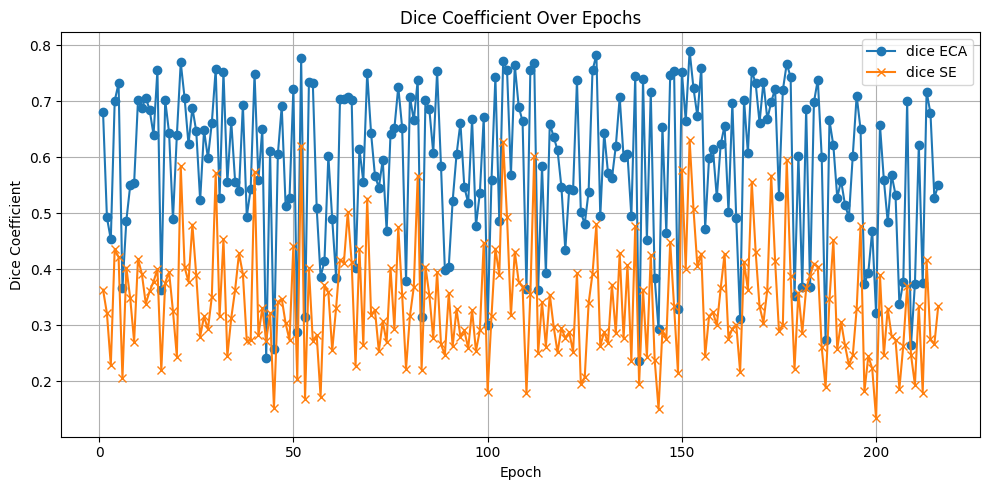

In [24]:

epochs = list(range(1, len(dice_SE) + 1))

# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(epochs, dice_ECA, label='dice ECA', marker='o')  # Plot the first list
plt.plot(epochs, dice_SE, label='dice SE', marker='x')  # Plot the second list

# Adding titles and labels
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()  # Show legend to identify the lines
plt.grid(True)  # Optionally add a grid for easier visualization
plt.tight_layout()  # Adjust the padding of the plot

# Show the plot
plt.show()

In [21]:
len(dice_SE)

216